In [1]:
# https://www.kaggle.com/datasets/yapwh1208/cats-breed-dataset
# https://www.kaggle.com/datasets/trolukovich/food11-image-dataset?select=training
# https://www.kaggle.com/datasets/gpiosenka/tree-nuts-image-classification?select=train

In [2]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor,InterpolationMode
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, classification_report
from tqdm.auto import tqdm
from collections import Counter

In [3]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
SEED = 50

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# root directory for data
root_dir = 'drive/MyDrive/'

Mounted at /content/drive


**DATA PREPROCESSING AND VISUALIZATION**

In [6]:
with zipfile.ZipFile(root_dir + 'food-11.zip', 'r') as zip_ref:
    zip_ref.extractall('food-11/')

In [7]:
image_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # resize the image
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # apply data augmentation
    transforms.ToTensor(), # convert the image into a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
train_data = datasets.ImageFolder('food-11/training/', transform=image_transform)
val_data = datasets.ImageFolder('food-11/validation/', transform=image_transform)
test_data = datasets.ImageFolder('food-11/evaluation/', transform=image_transform)

In [9]:
class_names = train_data.classes
print(class_names)

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


In [10]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

9866
3430
3347


In [11]:
image,label = train_data[0]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
0


Text(0.5, 1.0, 'Bread')

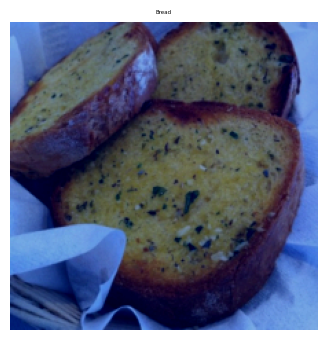

In [12]:
# rearrange the image dimensions
image_permute = image.permute(1,2,0)

# display the image
plt.figure(figsize=(6,4))
plt.imshow(image_permute)
plt.axis("off")
plt.title(train_data.classes[label], fontsize=4)

In [13]:
BATCH_SIZE = 64

# convert dataset to dataloader
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

val_dataloader = DataLoader(val_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [14]:
# get a batch of images and labels from the dataloader
train_images,train_labels = next(iter(train_dataloader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


**TRAINING**

In [15]:
# function to calculate accuracy
def accuracy(labels,preds):
    correct = torch.eq(labels,preds).sum().item()
    acc = (correct/len(labels))*100
    return acc

In [16]:
def train(model, dataloader, criterion, optimizer):
    # set the model to training mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (images, labels) in enumerate(dataloader):
        # send data to target device
        images, labels = images.to(device), labels.to(device)

        # pass the data to the model and get model outputs
        logits = model(images)

        # calulate the loss
        loss = criterion(logits, labels)
        train_loss += loss.item()

        # clear the gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # update the model parameters
        optimizer.step()

        # calculate the accuracy
        train_acc = train_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    train_loss = train_loss / len(dataloader)

    # calculate the mean accuracy
    train_acc = train_acc / len(dataloader)

    return train_loss,train_acc

In [17]:
def test(model, dataloader, criterion):
    # set the model to evaluation mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # send data to target device
            images, labels = images.to(device), labels.to(device)

            # pass the data to the model and get model outputs
            logits = model(images)

            # calulate the loss
            loss = criterion(logits, labels)
            test_loss += loss.item()

            # calculate the accuracy
            test_acc = test_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    test_loss = test_loss / len(dataloader)

    # calculate the mean accuracy
    test_acc = test_acc / len(dataloader)

    return test_loss,test_acc

In [18]:
def evaluate(model, dataloader, class_names):
    # set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []
    all_top5_preds = []

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            # get predictions from the model
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            top5_preds = torch.topk(logits, k=5, dim=1).indices  # Get top 5 predictions

            # accumulate predictions and true labels
            all_preds = all_preds + preds.cpu().tolist()
            all_labels = all_labels + labels.cpu().tolist()
            all_top5_preds = all_top5_preds + top5_preds.cpu().tolist()

    # convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_top5_preds = np.array(all_top5_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)

    # calculate top-5 accuracy
    top5_correct = 0
    for i in range(len(all_labels)):
        if all_labels[i] in all_top5_preds[i]:
            top5_correct += 1
    top5_accuracy = top5_correct / len(all_labels)

    # calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # print metrics
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}\n")
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_accuracy[i]:.4f}")

    return balanced_accuracy

In [19]:
# function to plot the loss and accuracy
def plot_curves(results):
    colors = ['b','g','r','y']

    # plot training losses for all models
    plt.figure(figsize=(8, 6))
    for i,(model, losses) in enumerate(results.items()):
        epochs = range(1, len(losses['train_loss']) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.plot(epochs, losses['train_loss'], label=f"{model[0]} Optimizer with LR {model[1]}", color=colors[i], linestyle='-', linewidth=2, marker='D', markersize=5)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # plot validation losses for all models
    plt.figure(figsize=(8, 6))
    for i,(model, losses) in enumerate(results.items()):
        epochs = range(1, len(losses['val_loss']) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.plot(epochs, losses['val_loss'], label=f"{model[0]} with LR {model[1]}", color=colors[i], linestyle='-', linewidth=2, marker='D', markersize=5)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

**ALEXNET**

In [20]:
epochs = 6

results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 124MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2262 | train_acc: 41.78% | val_loss: 1.3480 | val_acc: 57.09%
Epoch: 2 | train_loss: 1.4545 | train_acc: 51.92% | val_loss: 1.2216 | val_acc: 63.69%
Epoch: 3 | train_loss: 1.3505 | train_acc: 55.33% | val_loss: 1.2240 | val_acc: 63.60%
Epoch: 4 | train_loss: 1.3057 | train_acc: 56.85% | val_loss: 1.1937 | val_acc: 65.12%
Epoch: 5 | train_loss: 1.2624 | train_acc: 58.43% | val_loss: 1.1908 | val_acc: 64.81%
Epoch: 6 | train_loss: 1.2191 | train_acc: 60.51% | val_loss: 1.0893 | val_acc: 66.24%


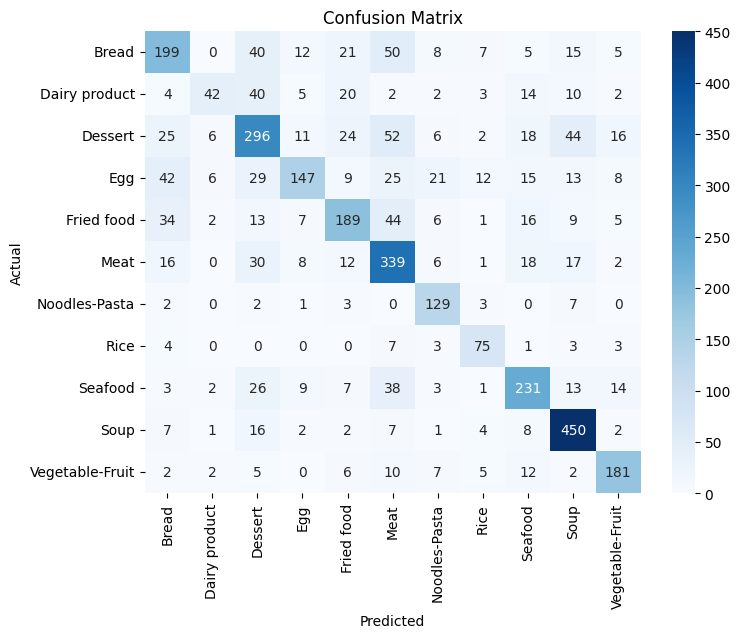

Overall Accuracy: 0.6641
Top-5 Accuracy: 0.9478
Balanced Accuracy: 0.6566


Per-Class Accuracy:
Bread: 0.5497
Dairy product: 0.2917
Dessert: 0.5920
Egg: 0.4495
Fried food: 0.5798
Meat: 0.7550
Noodles-Pasta: 0.8776
Rice: 0.7812
Seafood: 0.6657
Soup: 0.9000
Vegetable-Fruit: 0.7802

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4127 | train_acc: 52.91% | val_loss: 1.1171 | val_acc: 62.94%
Epoch: 2 | train_loss: 1.0585 | train_acc: 64.42% | val_loss: 0.9558 | val_acc: 67.57%
Epoch: 3 | train_loss: 0.9450 | train_acc: 68.21% | val_loss: 1.0060 | val_acc: 66.99%
Epoch: 4 | train_loss: 0.8849 | train_acc: 69.88% | val_loss: 0.9129 | val_acc: 68.68%
Epoch: 5 | train_loss: 0.8364 | train_acc: 71.86% | val_loss: 0.9359 | val_acc: 68.55%
Epoch: 6 | train_loss: 0.7914 | train_acc: 73.00% | val_loss: 0.8642 | val_acc: 70.88%


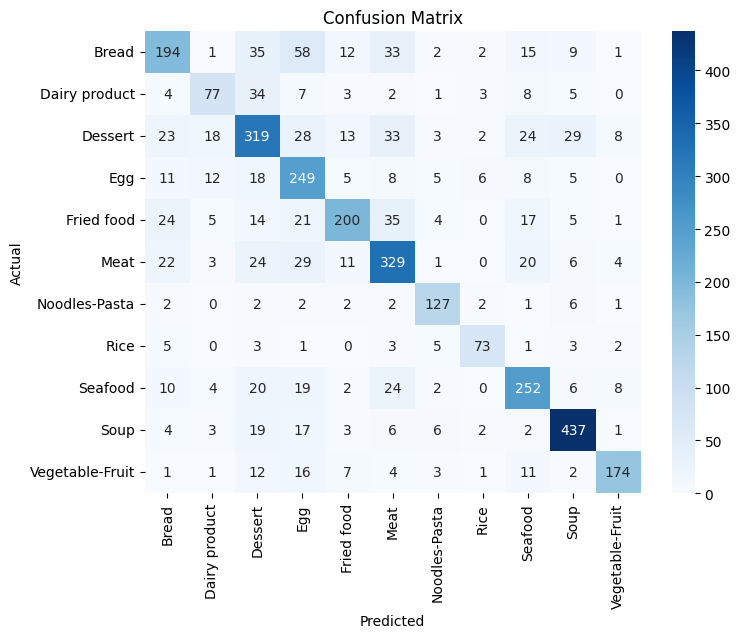

Overall Accuracy: 0.7087
Top-5 Accuracy: 0.9656
Balanced Accuracy: 0.7083


Per-Class Accuracy:
Bread: 0.5359
Dairy product: 0.5347
Dessert: 0.6380
Egg: 0.7615
Fried food: 0.6135
Meat: 0.7327
Noodles-Pasta: 0.8639
Rice: 0.7604
Seafood: 0.7262
Soup: 0.8740
Vegetable-Fruit: 0.7500

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 35.8745 | train_acc: 38.23% | val_loss: 1.5559 | val_acc: 49.26%
Epoch: 2 | train_loss: 1.4256 | train_acc: 53.05% | val_loss: 1.2738 | val_acc: 58.74%
Epoch: 3 | train_loss: 1.2925 | train_acc: 57.68% | val_loss: 1.2403 | val_acc: 58.06%
Epoch: 4 | train_loss: 1.2278 | train_acc: 60.15% | val_loss: 1.1419 | val_acc: 65.64%
Epoch: 5 | train_loss: 1.1670 | train_acc: 61.79% | val_loss: 1.1461 | val_acc: 63.68%
Epoch: 6 | train_loss: 1.1428 | train_acc: 62.81% | val_loss: 1.0951 | val_acc: 65.82%


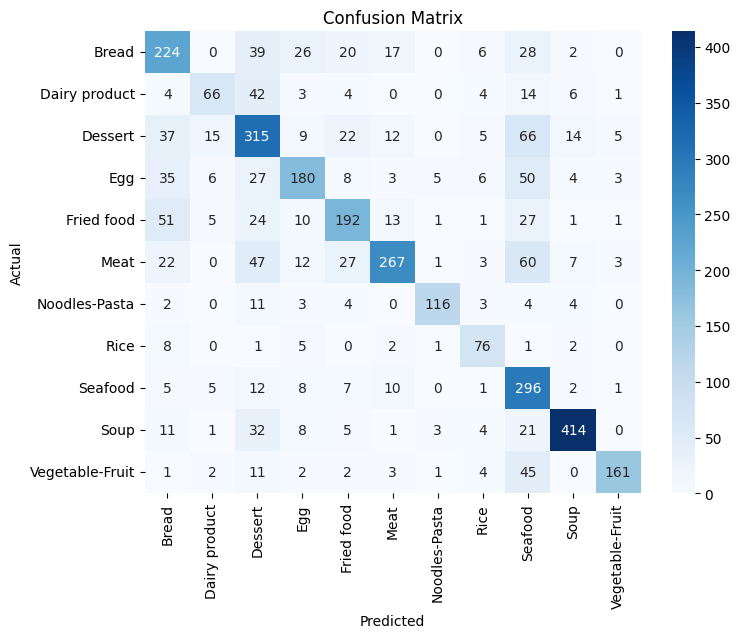

Overall Accuracy: 0.6726
Top-5 Accuracy: 0.9577
Balanced Accuracy: 0.6725


Per-Class Accuracy:
Bread: 0.6188
Dairy product: 0.4583
Dessert: 0.6300
Egg: 0.5505
Fried food: 0.5890
Meat: 0.5947
Noodles-Pasta: 0.7891
Rice: 0.7917
Seafood: 0.8530
Soup: 0.8280
Vegetable-Fruit: 0.6940

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7107 | train_acc: 51.28% | val_loss: 1.4832 | val_acc: 49.01%
Epoch: 2 | train_loss: 1.0651 | train_acc: 64.12% | val_loss: 1.1431 | val_acc: 63.02%
Epoch: 3 | train_loss: 0.9669 | train_acc: 67.41% | val_loss: 1.0322 | val_acc: 65.40%
Epoch: 4 | train_loss: 0.9087 | train_acc: 69.81% | val_loss: 0.9478 | val_acc: 68.96%
Epoch: 5 | train_loss: 0.8495 | train_acc: 71.04% | val_loss: 0.9302 | val_acc: 70.29%
Epoch: 6 | train_loss: 0.7991 | train_acc: 73.09% | val_loss: 1.0747 | val_acc: 64.58%


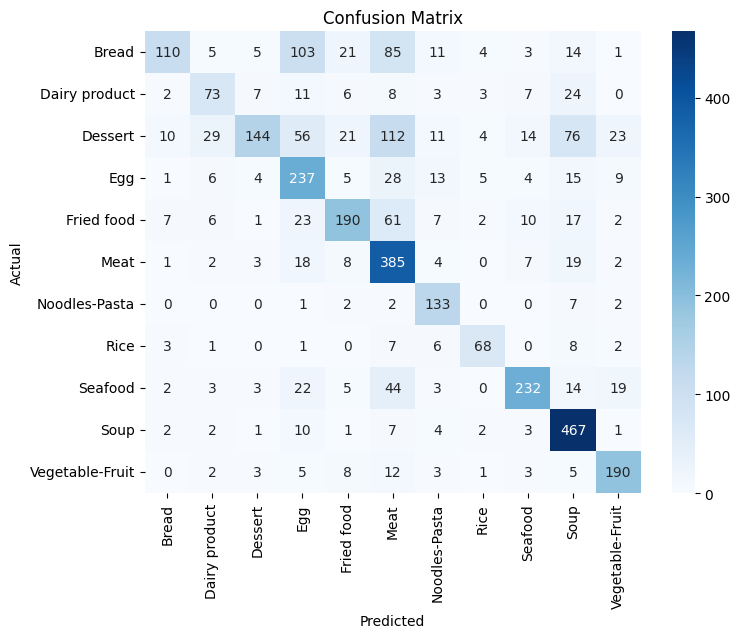

Overall Accuracy: 0.6499
Top-5 Accuracy: 0.9548
Balanced Accuracy: 0.6635


Per-Class Accuracy:
Bread: 0.3039
Dairy product: 0.5069
Dessert: 0.2880
Egg: 0.7248
Fried food: 0.5828
Meat: 0.8575
Noodles-Pasta: 0.9048
Rice: 0.7083
Seafood: 0.6686
Soup: 0.9340
Vegetable-Fruit: 0.8190


In [21]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.AlexNet_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.alexnet(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.features.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(9216,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,len(train_data.classes))
        ).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        evaluate(model, val_dataloader, class_names)

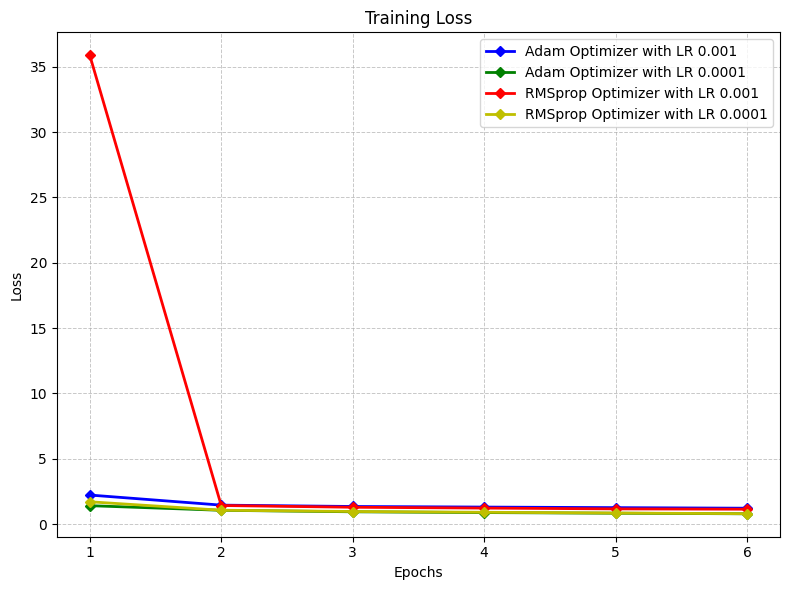

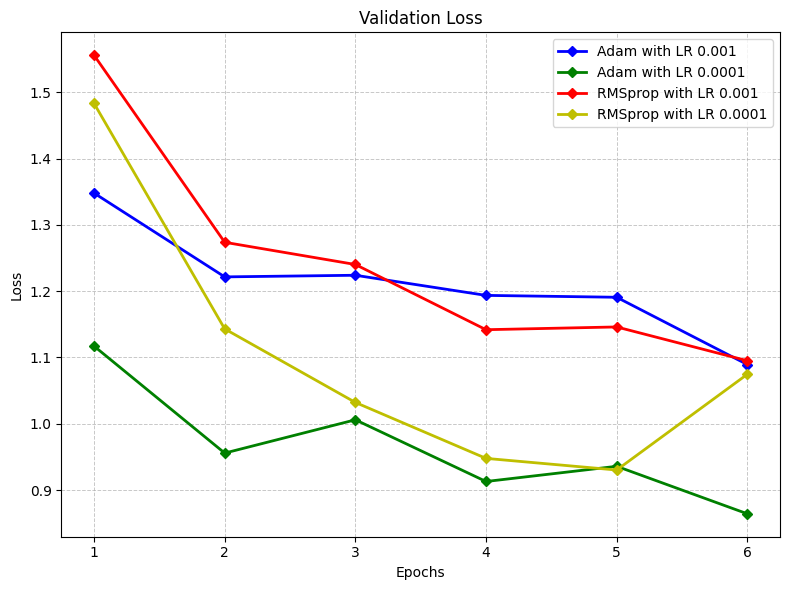

In [22]:
plot_curves(results)

**VGG-16**

In [ ]:
epochs = 6

results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 166MB/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7382 | train_acc: 56.55% | val_loss: 0.9602 | val_acc: 69.17%
Epoch: 2 | train_loss: 1.0369 | train_acc: 67.80% | val_loss: 0.8588 | val_acc: 71.88%
Epoch: 3 | train_loss: 0.9672 | train_acc: 70.06% | val_loss: 0.8780 | val_acc: 72.46%
Epoch: 4 | train_loss: 0.9682 | train_acc: 71.69% | val_loss: 0.9152 | val_acc: 71.56%


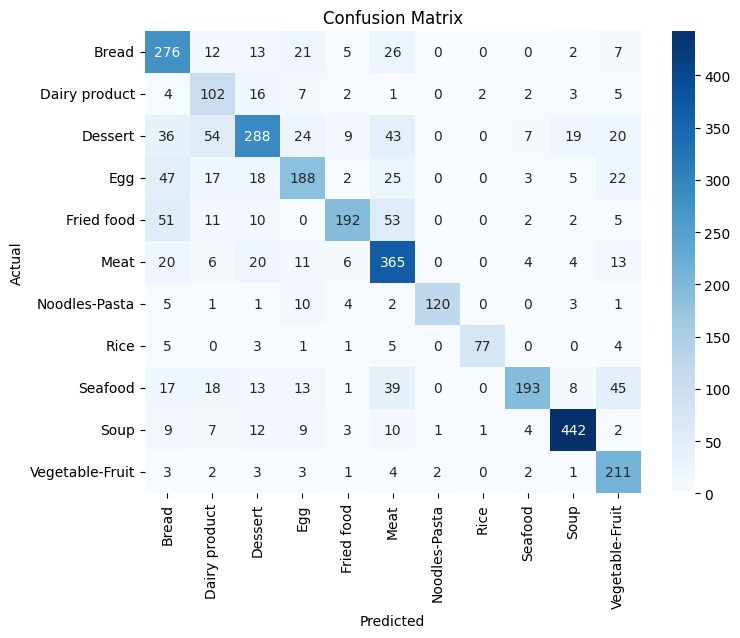

              precision    recall  f1-score   support

           0       0.58      0.76      0.66       362
           1       0.44      0.71      0.55       144
           2       0.73      0.58      0.64       500
           3       0.66      0.57      0.61       327
           4       0.85      0.59      0.70       326
           5       0.64      0.81      0.71       449
           6       0.98      0.82      0.89       147
           7       0.96      0.80      0.88        96
           8       0.89      0.56      0.68       347
           9       0.90      0.88      0.89       500
          10       0.63      0.91      0.74       232

    accuracy                           0.72      3430
   macro avg       0.75      0.73      0.72      3430
weighted avg       0.75      0.72      0.72      3430

Balanced Accuracy: 0.7265


Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.VGG16_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.vgg16(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.features.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.classifier = nn.Sequential(
            nn.Linear(25088,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,len(train_data.classes))
        ).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        evaluate(model, val_dataloader, class_names)

In [ ]:
plot_curves(results)

**RESNET-18**

In [ ]:
epochs = 6

results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5322 | train_acc: 51.86% | val_loss: 1.1360 | val_acc: 65.01%
Epoch: 2 | train_loss: 1.0176 | train_acc: 67.87% | val_loss: 0.9619 | val_acc: 70.00%
Epoch: 3 | train_loss: 0.9154 | train_acc: 70.00% | val_loss: 0.8900 | val_acc: 71.05%
Epoch: 4 | train_loss: 0.8703 | train_acc: 71.64% | val_loss: 0.8359 | val_acc: 72.52%
Epoch: 5 | train_loss: 0.8212 | train_acc: 73.13% | val_loss: 0.8515 | val_acc: 71.41%
Epoch: 6 | train_loss: 0.8015 | train_acc: 73.61% | val_loss: 0.8674 | val_acc: 71.31%


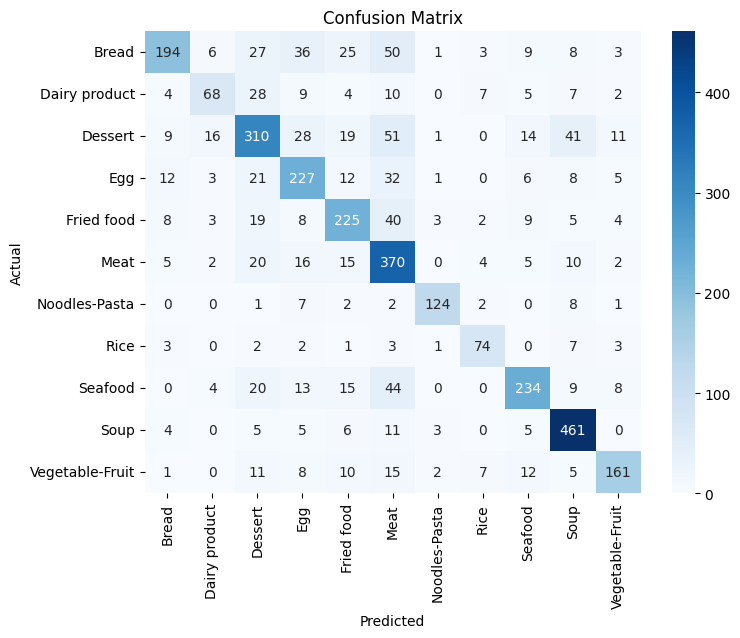

Overall Accuracy: 0.7137
Top-5 Accuracy: 0.9647

Per-Class Accuracy:
Bread: 0.5359
Dairy product: 0.4722
Dessert: 0.6200
Egg: 0.6942
Fried food: 0.6902
Meat: 0.8241
Noodles-Pasta: 0.8435
Rice: 0.7708
Seafood: 0.6744
Soup: 0.9220
Vegetable-Fruit: 0.6940

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2290 | train_acc: 21.44% | val_loss: 2.0274 | val_acc: 30.90%
Epoch: 2 | train_loss: 1.8677 | train_acc: 38.94% | val_loss: 1.7557 | val_acc: 44.14%
Epoch: 3 | train_loss: 1.6379 | train_acc: 50.42% | val_loss: 1.5618 | val_acc: 53.30%
Epoch: 4 | train_loss: 1.4713 | train_acc: 56.99% | val_loss: 1.4238 | val_acc: 58.36%
Epoch: 5 | train_loss: 1.3573 | train_acc: 60.29% | val_loss: 1.3325 | val_acc: 61.13%
Epoch: 6 | train_loss: 1.2750 | train_acc: 62.50% | val_loss: 1.2581 | val_acc: 62.57%


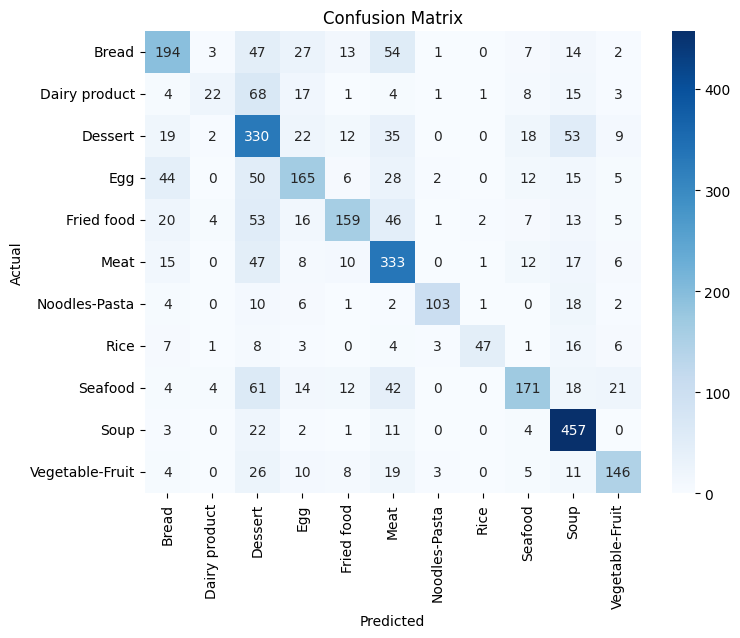

Overall Accuracy: 0.6201
Top-5 Accuracy: 0.9408

Per-Class Accuracy:
Bread: 0.5359
Dairy product: 0.1528
Dessert: 0.6600
Egg: 0.5046
Fried food: 0.4877
Meat: 0.7416
Noodles-Pasta: 0.7007
Rice: 0.4896
Seafood: 0.4928
Soup: 0.9140
Vegetable-Fruit: 0.6293

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4139 | train_acc: 55.78% | val_loss: 1.1396 | val_acc: 62.92%
Epoch: 2 | train_loss: 0.9741 | train_acc: 68.52% | val_loss: 1.0160 | val_acc: 66.72%
Epoch: 3 | train_loss: 0.8990 | train_acc: 70.76% | val_loss: 0.9467 | val_acc: 68.27%
Epoch: 4 | train_loss: 0.8547 | train_acc: 71.73% | val_loss: 0.9831 | val_acc: 68.01%
Epoch: 5 | train_loss: 0.8337 | train_acc: 71.91% | val_loss: 1.0238 | val_acc: 65.30%
Epoch: 6 | train_loss: 0.8068 | train_acc: 73.10% | val_loss: 0.9773 | val_acc: 68.10%


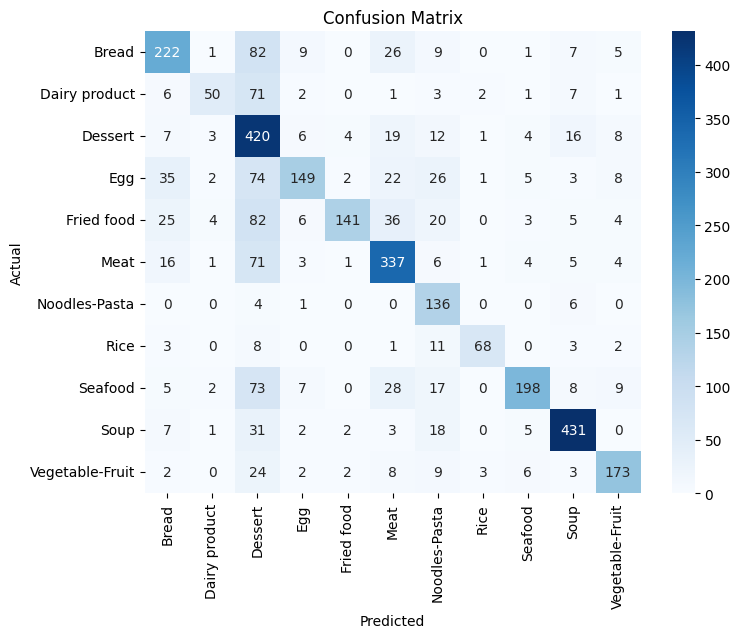

Overall Accuracy: 0.6778
Top-5 Accuracy: 0.9571

Per-Class Accuracy:
Bread: 0.6133
Dairy product: 0.3472
Dessert: 0.8400
Egg: 0.4557
Fried food: 0.4325
Meat: 0.7506
Noodles-Pasta: 0.9252
Rice: 0.7083
Seafood: 0.5706
Soup: 0.8620
Vegetable-Fruit: 0.7457

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9754 | train_acc: 33.67% | val_loss: 1.7768 | val_acc: 45.23%
Epoch: 2 | train_loss: 1.6575 | train_acc: 49.86% | val_loss: 1.5725 | val_acc: 53.69%
Epoch: 3 | train_loss: 1.4738 | train_acc: 56.55% | val_loss: 1.4222 | val_acc: 57.65%
Epoch: 4 | train_loss: 1.3546 | train_acc: 60.61% | val_loss: 1.3096 | val_acc: 62.09%
Epoch: 5 | train_loss: 1.2656 | train_acc: 63.11% | val_loss: 1.2321 | val_acc: 63.48%
Epoch: 6 | train_loss: 1.1986 | train_acc: 64.95% | val_loss: 1.1844 | val_acc: 64.89%


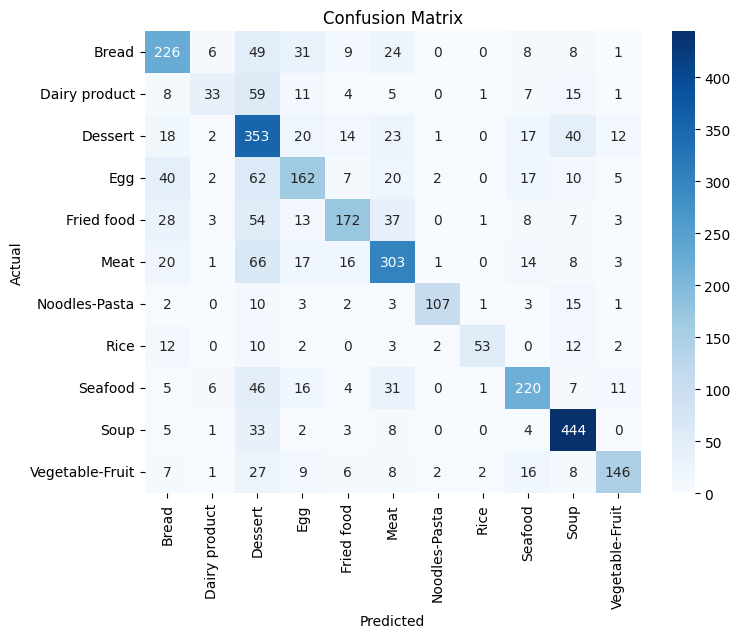

Overall Accuracy: 0.6469
Top-5 Accuracy: 0.9475

Per-Class Accuracy:
Bread: 0.6243
Dairy product: 0.2292
Dessert: 0.7060
Egg: 0.4954
Fried food: 0.5276
Meat: 0.6748
Noodles-Pasta: 0.7279
Rice: 0.5521
Seafood: 0.6340
Soup: 0.8880
Vegetable-Fruit: 0.6293


In [ ]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.ResNet18_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.resnet18(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.fc = nn.Linear(512,len(train_data.classes)).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        evaluate(model, val_dataloader, class_names)

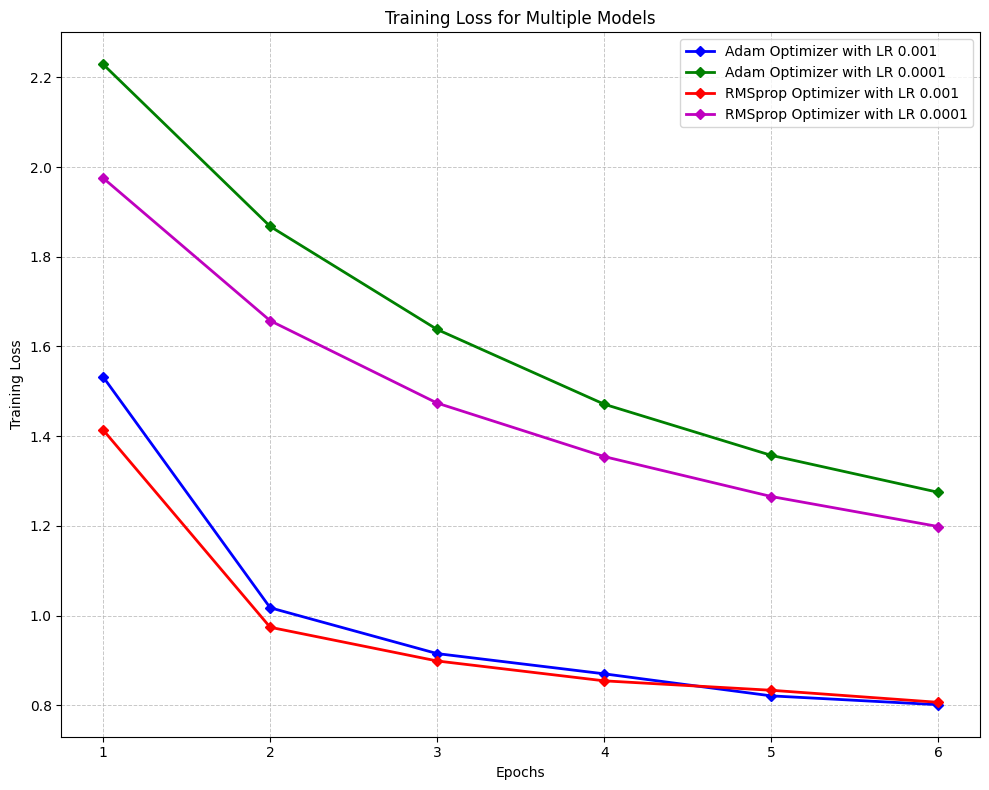

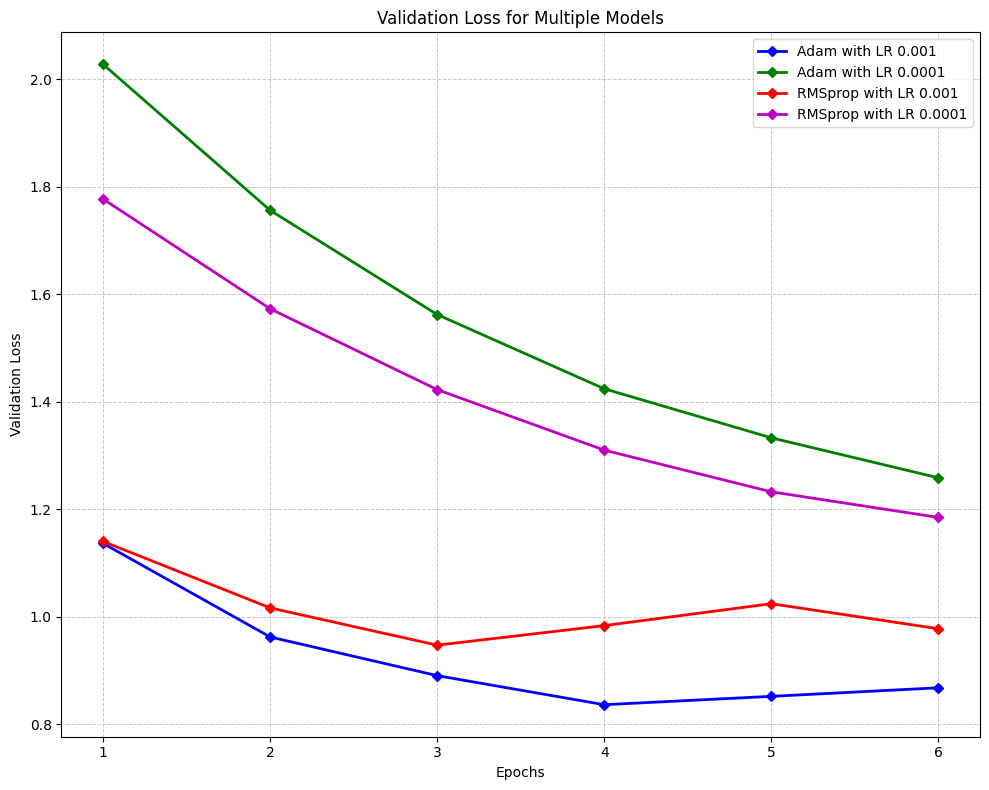

In [ ]:
plot_curves(results)

**TESTING THE BEST MODEL**

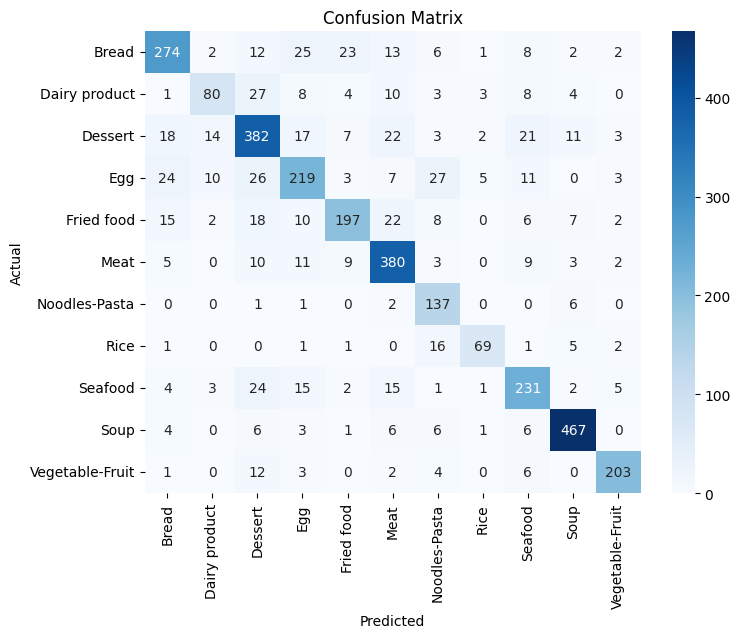

Overall Accuracy: 0.7885
Top-5 Accuracy: 0.9779

Per-Class Accuracy:
Bread: 0.7446
Dairy product: 0.5405
Dessert: 0.7640
Egg: 0.6537
Fried food: 0.6864
Meat: 0.8796
Noodles-Pasta: 0.9320
Rice: 0.7188
Seafood: 0.7624
Soup: 0.9340
Vegetable-Fruit: 0.8788


In [ ]:
# evaluate the model on the test set
evaluate(model, test_dataloader, class_names)

1. Which models out of - VGG-16, VGG-19, ResNet-18, ResNet-34, ResNet-50 - ANY ?
2. Which dataset to use - ANY ?
3. Choose baseline model